In [1]:
import os

os.environ['KAGGLE_USERNAME'] = 'rifqinovandi'
os.environ['KAGGLE_KEY'] = '03877f2b4798e3c6def8f76fd42e3070'

In [2]:
!kaggle datasets download -d saadhaxxan/germantrafficsigns

100% 118M/118M [00:03<00:00, 41.4MB/s]



In [3]:
import zipfile

files = "/content/germantrafficsigns.zip"
zip = zipfile.ZipFile(files, 'r')
zip.extractall('/content')
zip.close()

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [5]:
## Load the data
training_file = "/content/train.p"
testing_file = "/content/test.p"   
 
# Open and load the training file 
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
 
# Open and load the training file
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
print("Data loaded")

Data loaded


In [6]:
## The content of csv file is ClassId and the SignName
 
sign_name_df = pd.read_csv('/content/signnames.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [7]:
X, y = train['features'], train['labels']

data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

X_test, y_test = test['features'], test['labels']

X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [8]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


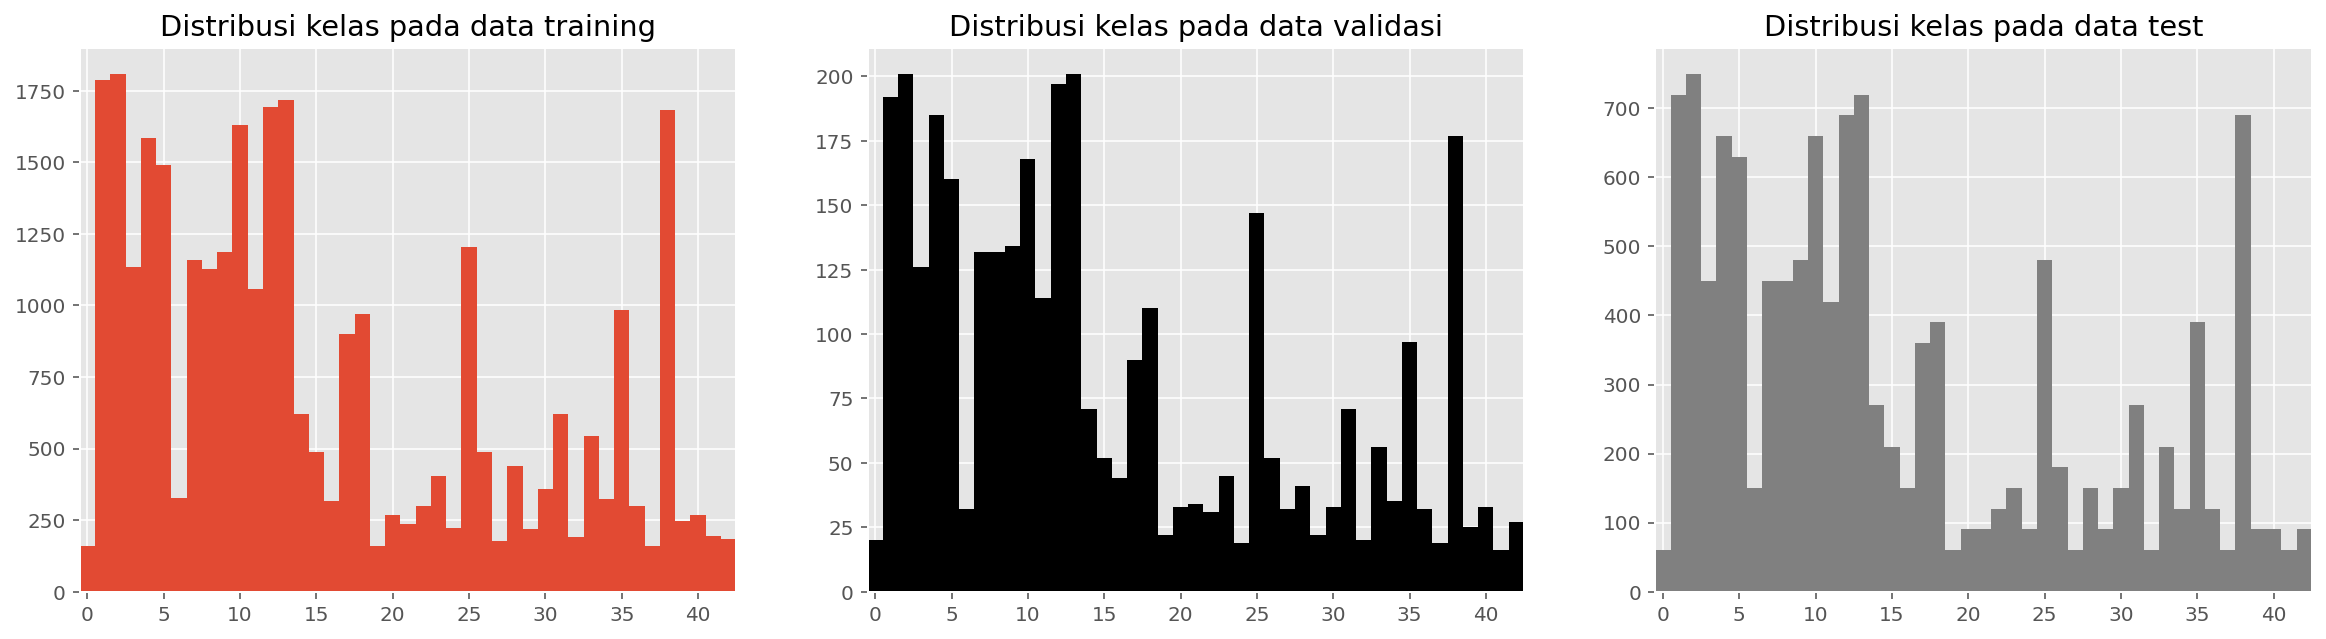

In [9]:
n_labels = np.unique(y_train).size
def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax :
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs : ax.legend()
    if title : ax.set_title(title)
        
fig,ax = plt.subplots(1,3, figsize=(20,5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [10]:
from tensorflow.keras.utils import to_categorical
 
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)

In [11]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.96 and logs.get('val_accuracy') > 0.96):
      print("\nAkurasi telah mencapai >96%. Stop training!")
      self.model.stop_training = True
callbacks = myCallback()

In [12]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        2432      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0

In [13]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val), callbacks=[callbacks])
model.save('German Traffic Sign Model.h5')

Epoch 1/25
979/979 [==============================] - 39s 9ms/step - loss: 1.3542 - accuracy: 0.6619 - val_loss: 0.1663 - val_accuracy: 0.9592
Epoch 2/25
979/979 [==============================] - 8s 8ms/step - loss: 0.3078 - accuracy: 0.9127 - val_loss: 0.0973 - val_accuracy: 0.9790
Epoch 3/25
979/979 [==============================] - 8s 8ms/step - loss: 0.2153 - accuracy: 0.9396 - val_loss: 0.0989 - val_accuracy: 0.9793
Epoch 4/25
979/979 [==============================] - 8s 8ms/step - loss: 0.1873 - accuracy: 0.9481 - val_loss: 0.0539 - val_accuracy: 0.9897
Epoch 5/25
979/979 [==============================] - 8s 8ms/step - loss: 0.1805 - accuracy: 0.9514 - val_loss: 0.0390 - val_accuracy: 0.9905
Epoch 6/25
979/979 [==============================] - 8s 8ms/step - loss: 0.1813 - accuracy: 0.9531 - val_loss: 0.0499 - val_accuracy: 0.9871
Epoch 7/25
979/979 [==============================] - 8s 8ms/step - loss: 0.1651 - accuracy: 0.9577 - val_loss: 0.0526 - val_accuracy: 0.9891
Epoch

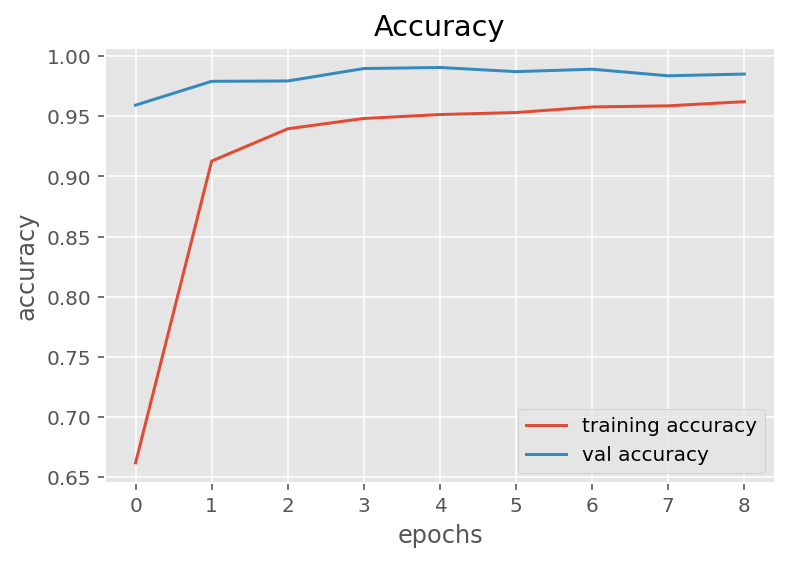

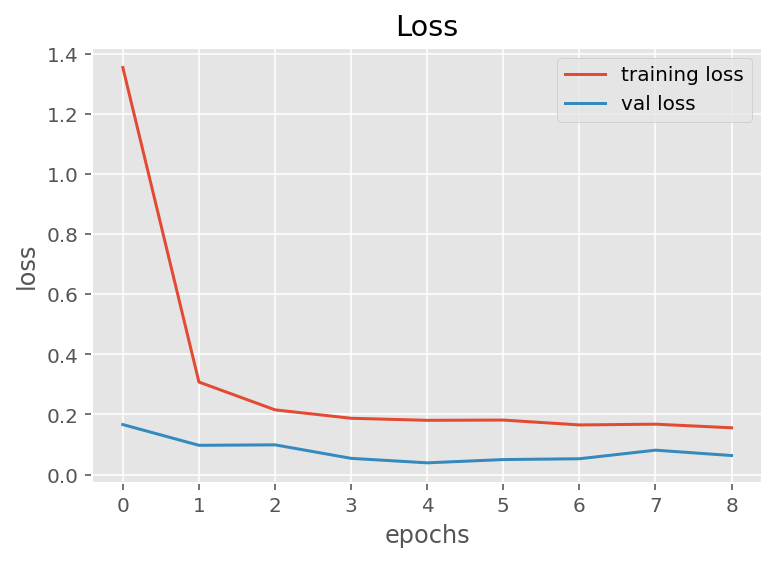

In [14]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
 
# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [16]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

0.9471100554235946

In [17]:
from sklearn.metrics import classification_report
 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        60
           1       0.92      0.97      0.95       720
           2       0.98      0.99      0.98       750
           3       0.92      0.96      0.94       450
           4       0.98      0.96      0.97       660
           5       0.97      0.87      0.92       630
           6       1.00      0.56      0.72       150
           7       0.98      0.96      0.97       450
           8       0.97      0.95      0.96       450
           9       0.97      1.00      0.98       480
          10       1.00      0.97      0.98       660
          11       0.92      0.94      0.93       420
          12       0.99      0.98      0.98       690
          13       0.99      1.00      0.99       720
          14       1.00      0.96      0.98       270
          15       0.90      1.00      0.95       210
          16       0.97      1.00      0.99       150
          17       1.00    